In [506]:
#!pip install catboost 

In [507]:
# Импорт библиотек
import pandas as pd
import numpy as np
import json
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from category_encoders.target_encoder import TargetEncoder
import sklearn.metrics
import math
import matplotlib.pyplot as plt

In [508]:
# Загрузка датасетов
train_data = pd.read_csv('train.csv')
test_data  = pd.read_csv('test.csv')

In [509]:
train_data[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [510]:
train_data.shape, test_data.shape

((3000, 23), (4398, 22))

In [511]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [512]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

In [513]:
# Запишем в отдельную переменную поля в формате json
json_type_columns = ['belongs_to_collection', 'genres', 'spoken_languages', 'Keywords', 'cast', 'crew', 'production_companies', 'production_countries']

In [514]:
train_data[json_type_columns][:3]

,belongs_to_collection,genres,spoken_languages,Keywords,cast,crew,production_companies,production_countries
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...","[{'id': 35, 'name': 'Comedy'}]","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o..."
1,"[{'id': 107674, 'name': 'The Princess Diaries ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...","[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o..."
2,NaN,"[{'id': 18, 'name': 'Drama'}]","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...","[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o..."


In [515]:
#train_data.loc[:, 'cast'][0]

In [516]:
#[i for i in train_data['belongs_to_collection'].values]

In [517]:
# Создадим копию тестового и тренирровочного датасетов и будем работать только с ними
train_data_c = train_data.copy()
test_data_c = test_data.copy()

## Работа с признаками

In [518]:
# Общая предобработка json полей 
for col in json_type_columns:
    new_col = []
    for i in train_data_c[col]:
        #print(i)
        if i==i:
            new_col.append(eval(i))
        else:
            new_col.append([])
    train_data_c.loc[:, col] = new_col
    
for col in json_type_columns:
    new_col = []
    for i in test_data_c[col]:
        #print(i)
        if i==i:
            new_col.append(eval(i))
        else:
            new_col.append([])
    test_data_c.loc[:, col] = new_col

D:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


#### belongs_to_collection

In [519]:
# Убедимся что фильм может пренадлежать максимум 1 коллекции + заполняемость
num_of_collect = []
for r in train_data_c['belongs_to_collection']:
    num_of_collect.append(len(r))

np.array(num_of_collect).max(), np.array(num_of_collect).sum()

(1, 604)

In [520]:
# Запишем название коллекции фильма если она есть, иначе 0
train_data_c['belongs_to_collection'] = train_data_c['belongs_to_collection'].apply(lambda x: x[0]['name'] if len(x)!=0 else np.nan)
test_data_c['belongs_to_collection'] = test_data_c['belongs_to_collection'].apply(lambda x: x[0]['name'] if len(x)!=0 else np.nan)

In [521]:
train_data_c['belongs_to_collection'].value_counts()

James Bond Collection                     16
Friday the 13th Collection                 7
The Pink Panther (Original) Collection     6
Police Academy Collection                  5
Pokémon Collection                         5
                                          ..
Pitch Perfect Collection                   1
Alpha and Omega Collection                 1
Bad Boys Collection                        1
F*ck You, Goethe Collection                1
Save The Last Dance Collection             1
Name: belongs_to_collection, Length: 422, dtype: int64

In [522]:
train_data_c['has_collection'] = train_data_c['belongs_to_collection'].apply(lambda x: 1 if x==x else 0)
test_data_c['has_collection'] = test_data_c['belongs_to_collection'].apply(lambda x: 1 if x==x else 0)

In [523]:
#train_data_c.sample(10)

#### genres

In [524]:
train_data_c['genres'][:5]

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [525]:
# Определим список возможных жанров
genres_dict = {}
for r in train_data_c['genres']:
    for i in r:
        if not i['id'] in genres_dict.values():
            genres_dict[i['id']] = i['name']

# Получим отсортированный по названию словарь жанров с ID и выведем на экран            
genres_dict = dict(sorted(genres_dict.items(), key=lambda x: x[1]))
genres_dict

{28: 'Action',
 12: 'Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 14: 'Fantasy',
 10769: 'Foreign',
 36: 'History',
 27: 'Horror',
 10402: 'Music',
 9648: 'Mystery',
 10749: 'Romance',
 878: 'Science Fiction',
 10770: 'TV Movie',
 53: 'Thriller',
 10752: 'War',
 37: 'Western'}

In [526]:
def get_feature_val(row, key_name='id'):
    values_list = []
    for d in row:
        values_list.append(d.get(key_name, -999))
    return values_list

In [527]:
train_data_c['genres'] = train_data_c['genres'].apply(get_feature_val)
test_data_c['genres'] = test_data_c['genres'].apply(get_feature_val)

In [528]:
train_data_c[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,has_collection
0,1,Hot Tub Time Machine Collection,14000000,[35],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1
1,2,The Princess Diaries Collection,40000000,"[35, 18, 10751, 10749]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,1
2,3,NaN,3300000,[18],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0


На мой взгляд, жанр фильма - очень важный признак при оценке предполагаемых сборов, поэтому для каждого жанра создадим поле, определяющее принадлежность к нему

In [529]:
for i in genres_dict.values():
    train_data_c[i] = 0
    test_data_c[i] = 0

In [530]:
for k, v in genres_dict.items():
    train_data_c[v] = np.where(train_data_c['genres'].apply(lambda x: k in x)==1, 1, 0)
    test_data_c[v] = np.where(test_data_c['genres'].apply(lambda x: k in x)==1, 1, 0)

In [531]:
train_data_c.sample(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
2826,2827,NaN,1500000,"[18, 80]",NaN,tt0113540,en,Kids,A controversial portrayal of teens in New York...,4.877872,...,0,0,0,0,0,0,0,0,0,0
518,519,Wonder Woman Collection,149000000,"[28, 12, 14]",http://www.warnerbros.com/wonder-woman,tt0451279,en,Wonder Woman,An Amazon princess comes to the world of Man t...,294.337037,...,0,0,0,0,0,0,0,0,0,0
929,930,NaN,5000000,"[10751, 14, 878, 12, 35]",NaN,tt0081633,en,Time Bandits,Young history buff Kevin can scarcely believe ...,9.841623,...,0,0,0,0,0,1,0,0,0,0


#### spoken_languages

In [532]:
train_data_c['spoken_languages']

0                [{'iso_639_1': 'en', 'name': 'English'}]
1                [{'iso_639_1': 'en', 'name': 'English'}]
2                [{'iso_639_1': 'en', 'name': 'English'}]
3       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4                [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
                              ...                        
2995             [{'iso_639_1': 'en', 'name': 'English'}]
2996             [{'iso_639_1': 'sv', 'name': 'svenska'}]
2997             [{'iso_639_1': 'en', 'name': 'English'}]
2998             [{'iso_639_1': 'en', 'name': 'English'}]
2999             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, Length: 3000, dtype: object

In [533]:
languages_dict = {}
languages_count = {}
for r in train_data_c['spoken_languages']:
    for i in r:
        if not i['iso_639_1'] in languages_dict.values():
            languages_dict[i['iso_639_1']] = i['name']
            
        languages_count[i['iso_639_1']] = languages_count.get(i['iso_639_1'], 0) + 1          

In [534]:
#languages_count

In [535]:
#languages_dict

Языков довольно много, поэтому сделаем несколько признаков:\
    1 - Кол-во языков\
    2 - Принадлежность к топ 10 самых популярных

In [536]:
# Выведем список языкв, отсортированный от популярных к менее популярным. В качестве ключа используем метку языка iso_639_1 так как она есть у всех языков
languages_count_sorted = dict(sorted(languages_count.items(), key=lambda x: x[1], reverse=True))

In [537]:
#languages_count_sorted

In [538]:
train_data_c['spoken_languages'] = train_data_c['spoken_languages'].apply(lambda x: get_feature_val(x, 'iso_639_1'))
test_data_c['spoken_languages'] = test_data_c['spoken_languages'].apply(lambda x: get_feature_val(x, 'iso_639_1'))

In [539]:
train_data_c['spoken_languages']

0           [en]
1           [en]
2           [en]
3       [en, hi]
4           [ko]
          ...   
2995        [en]
2996        [sv]
2997        [en]
2998        [en]
2999        [en]
Name: spoken_languages, Length: 3000, dtype: object

In [540]:
train_data_c['spoken_languages_cnt'] = train_data_c['spoken_languages'].apply(lambda x: len(set(x)))
test_data_c['spoken_languages_cnt'] = test_data_c['spoken_languages'].apply(lambda x: len(set(x)))

In [541]:
train_data_c['spoken_languages_cnt']

0       1
1       1
2       1
3       2
4       1
       ..
2995    1
2996    1
2997    1
2998    1
2999    1
Name: spoken_languages_cnt, Length: 3000, dtype: int64

In [542]:
for i in list(languages_count_sorted.keys())[:10]:
    train_data_c['spoken_languages_'+str(i)] = 0
    test_data_c['spoken_languages_'+str(i)] = 0

In [543]:
for v in list(languages_count_sorted.keys())[:10]:
    train_data_c['spoken_languages_'+str(v)] = np.where(train_data_c['spoken_languages'].apply(lambda x: v in x)==1, 1, 0)
    test_data_c['spoken_languages_'+str(v)] = np.where(test_data_c['spoken_languages'].apply(lambda x: v in x)==1, 1, 0)

In [544]:
train_data_c[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages_en,spoken_languages_fr,spoken_languages_es,spoken_languages_de,spoken_languages_ru,spoken_languages_it,spoken_languages_ja,spoken_languages_zh,spoken_languages_hi,spoken_languages_pt
0,1,Hot Tub Time Machine Collection,14000000,[35],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,1,0,0,0,0,0,0,0,0,0
1,2,The Princess Diaries Collection,40000000,"[35, 18, 10751, 10749]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,1,0,0,0,0,0,0,0,0,0
2,3,NaN,3300000,[18],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,1,0,0,0,0,0,0,0,0,0


In [545]:
#test_data_c.columns.shape, train_data_c.columns.shape

#### Keywords

In [546]:
train_data_c['Keywords']

0       [{'id': 4379, 'name': 'time travel'}, {'id': 9...
1       [{'id': 2505, 'name': 'coronation'}, {'id': 42...
2       [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...
3       [{'id': 10092, 'name': 'mystery'}, {'id': 1054...
4                                                      []
                              ...                        
2995    [{'id': 378, 'name': 'prison'}, {'id': 572, 'n...
2996    [{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...
2997    [{'id': 441, 'name': 'assassination'}, {'id': ...
2998    [{'id': 966, 'name': 'beach'}, {'id': 2676, 'n...
2999    [{'id': 591, 'name': 'cia'}, {'id': 822, 'name...
Name: Keywords, Length: 3000, dtype: object

In [547]:
keywords_dict = {}
keywords_cnt = {}
for r in train_data_c['Keywords']:
    for i in r:
        if not i['id'] in keywords_dict.values():
            keywords_dict[i['id']] = i['name']
            
    keywords_cnt[i['id']] = keywords_cnt.get(i['id'], 0) + 1  

In [548]:
#keywords_dict

In [549]:
keywords_cnt_sorted = dict(sorted(keywords_cnt.items(), key=lambda x: x[1], reverse=True))

In [550]:
#keywords_cnt_sorted

In [551]:
train_data_c['Keywords'] = train_data_c['Keywords'].apply(get_feature_val)
test_data_c['Keywords'] = test_data_c['Keywords'].apply(get_feature_val)

In [552]:
train_data_c['Keywords'][:3]

0                          [4379, 9663, 11830, 179431]
1                            [2505, 4263, 6038, 13072]
2    [1416, 1523, 1640, 2176, 14512, 14819, 33896, ...
Name: Keywords, dtype: object

In [553]:
for ids in list(keywords_cnt_sorted.keys())[:10]:
    keyword = keywords_dict[ids]
    col_name = ('has_'+str(keyword)+'_keyword').replace(' ', '_')
    train_data_c[col_name] = 0
    test_data_c[col_name] = 0

In [554]:
for ids in list(keywords_cnt_sorted.keys())[:10]:
    keyword = keywords_dict[ids]
    col_name = ('has_'+str(keyword)+'_keyword').replace(' ', '_')
    train_data_c[col_name] = np.where(train_data_c['Keywords'].apply(lambda x: v in x)==1, 1, 0)
    test_data_c[col_name] = np.where(test_data_c['Keywords'].apply(lambda x: v in x)==1, 1, 0)

In [555]:
train_data_c[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,has_woman_director_keyword,has_duringcreditsstinger_keyword,has_independent_film_keyword,has_3d_keyword,has_aftercreditsstinger_keyword,has_based_on_young_adult_novel_keyword,has_family_keyword,has_sport_keyword,has_los_angeles_keyword,has_hoodlum_keyword
0,1,Hot Tub Time Machine Collection,14000000,[35],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,0,0
1,2,The Princess Diaries Collection,40000000,"[35, 18, 10751, 10749]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,0,0,0,0,0,0
2,3,NaN,3300000,[18],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,0,0


#### cast

In [556]:
#train_data_c['cast'][0]

In [557]:
cast_dict = {}
cast_cnt = {}
for r in train_data_c['cast']:
    for i in r:
        if not i['cast_id'] in cast_dict.values():
            cast_dict[i['cast_id']] = i['name']
            
        cast_cnt[i['cast_id']] = cast_cnt.get(i['cast_id'], 0) + 1  

In [558]:
cast_cnt_sorted = dict(sorted(cast_cnt.items(), key=lambda x: x[1], reverse=True))

In [559]:
#cast_cnt_sorted

In [560]:
#train_data_c['cast'][0]

Сделаем 2 фичи связанные с актерским составом:\
    1 - Кол-во актеров\
Хотел добавить кол-во актеров того или ного пола, но с определением пола в датасете проблематично

In [561]:
train_data_c['cast_cnt'] = train_data_c['cast'].apply(lambda x: len(set(get_feature_val(x, 'cast_id'))))
test_data_c['cast_cnt'] = test_data_c['cast'].apply(lambda x: len(set(get_feature_val(x, 'cast_id'))))

In [562]:
train_data_c[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,has_duringcreditsstinger_keyword,has_independent_film_keyword,has_3d_keyword,has_aftercreditsstinger_keyword,has_based_on_young_adult_novel_keyword,has_family_keyword,has_sport_keyword,has_los_angeles_keyword,has_hoodlum_keyword,cast_cnt
0,1,Hot Tub Time Machine Collection,14000000,[35],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,0,24
1,2,The Princess Diaries Collection,40000000,"[35, 18, 10751, 10749]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,0,0,0,0,0,20
2,3,NaN,3300000,[18],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,0,51


In [563]:
train_data_c['cast'] = train_data_c['cast'].apply(lambda x: get_feature_val(x, 'cast_id'))
test_data_c['cast'] = test_data_c['cast'].apply(lambda x: get_feature_val(x, 'cast_id'))

In [564]:
for ids in list(cast_cnt_sorted.keys())[:10]:
    cast = cast_dict[ids]
    col_name = ('with_'+str(cast)).replace(' ', '_')
    train_data_c[col_name] = 0
    test_data_c[col_name] = 0

In [565]:
for ids in list(cast_cnt_sorted.keys())[:10]:
    cast = cast_dict[ids]
    col_name = ('with_'+str(cast)).replace(' ', '_')
    train_data_c[col_name] = np.where(train_data_c['cast'].apply(lambda x: v in x)==1, 1, 0)
    test_data_c[col_name] = np.where(test_data_c['cast'].apply(lambda x: v in x)==1, 1, 0)

In [566]:
train_data_c.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'has_collection', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'spoken_languages_cnt',
       'spoken_languages_en', 'spoken_languages_fr', 'spoken_languages_es',
       'spoken_languages_de', 'spoken_languages_ru', 'spoken_languages_it',
       'spoken_languages_ja', 'spoken_languages_zh', 'spoken_languages_hi',
       'spoken_languages_pt', 'has_woman_director_keyword',
       'has_duringcreditsstinger_keyword', 'has_independent_film_

#### crew

In [567]:
train_data_c['crew']

0       [{'credit_id': '59ac067c92514107af02c8c8', 'de...
1       [{'credit_id': '52fe43fe9251416c7502563d', 'de...
2       [{'credit_id': '54d5356ec3a3683ba0000039', 'de...
3       [{'credit_id': '52fe48779251416c9108d6eb', 'de...
4       [{'credit_id': '52fe464b9251416c75073b43', 'de...
                              ...                        
2995    [{'credit_id': '52fe4494c3a368484e02ac7d', 'de...
2996    [{'credit_id': '5716b72ac3a3686678012c84', 'de...
2997    [{'credit_id': '52fe443a9251416c7502d579', 'de...
2998    [{'credit_id': '556f817b9251410866000a63', 'de...
2999    [{'credit_id': '5391990d0e0a260fb5001629', 'de...
Name: crew, Length: 3000, dtype: object

In [568]:
crew_dict = {}
crew_cnt = {}
job_set = set()
for r in train_data_c['crew']:
    for i in r:
        if not i['id'] in crew_dict.values():
            crew_dict[i['id']] = i['name']
            
        job_set.add(i['job']) # Хорошо было бы селекцию должностей провести, но их оказалось много, а я не разбираюсь
        crew_cnt[i['id']] = crew_cnt.get(i['id'], 0) + 1  

In [569]:
crew_cnt_sorted = dict(sorted(crew_cnt.items(), key=lambda x: x[1], reverse=True))

In [570]:
#crew_cnt_sorted

In [571]:
#train_data_c['crew'][0]

In [572]:
train_data_c['crew_cnt'] = train_data_c['crew'].apply(lambda x: len(set(get_feature_val(x, 'id'))))
test_data_c['crew_cnt'] = test_data_c['crew'].apply(lambda x: len(set(get_feature_val(x, 'id'))))

In [573]:
train_data_c[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,with_Lily_Collins,with_Jason_Isaacs,with_Maria_Bello,with_Taylor_Lautner,with_Jsu_Garcia,with_Alec_Baldwin,with_Bryan_Brown,with_Michael_Nyqvist,with_Hank_Azaria,crew_cnt
0,1,Hot Tub Time Machine Collection,14000000,[35],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,0,70
1,2,The Princess Diaries Collection,40000000,"[35, 18, 10751, 10749]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,0,0,0,0,0,9
2,3,NaN,3300000,[18],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,0,61


In [574]:
train_data_c['crew'] = train_data_c['crew'].apply(lambda x: get_feature_val(x, 'id'))
test_data_c['crew'] = test_data_c['crew'].apply(lambda x: get_feature_val(x, 'id'))

In [575]:
for ids in list(crew_cnt_sorted.keys())[:10]:
    crew = crew_dict[ids]
    col_name = ('mkwith_'+str(cast)).replace(' ', '_')
    train_data_c[col_name] = 0
    test_data_c[col_name] = 0

In [576]:
for ids in list(crew_cnt_sorted.keys())[:10]:
    crew = crew_dict[ids]
    col_name = ('mkwith_'+str(crew)).replace(' ', '_')
    train_data_c[col_name] = np.where(train_data_c['crew'].apply(lambda x: v in x)==1, 1, 0)
    test_data_c[col_name] = np.where(test_data_c['crew'].apply(lambda x: v in x)==1, 1, 0)

In [577]:
train_data_c.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'has_collection', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'spoken_languages_cnt',
       'spoken_languages_en', 'spoken_languages_fr', 'spoken_languages_es',
       'spoken_languages_de', 'spoken_languages_ru', 'spoken_languages_it',
       'spoken_languages_ja', 'spoken_languages_zh', 'spoken_languages_hi',
       'spoken_languages_pt', 'has_woman_director_keyword',
       'has_duringcreditsstinger_keyword', 'has_independent_film_

#### production_companies

In [578]:
train_data_c['production_companies']

0       [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1             [{'name': 'Walt Disney Pictures', 'id': 2}]
2       [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                      []
4                                                      []
                              ...                        
2995    [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
2996    [{'name': 'Memfis Film', 'id': 321}, {'name': ...
2997    [{'name': 'New Line Cinema', 'id': 12}, {'name...
2998    [{'name': 'Jersey Films', 'id': 216}, {'name':...
2999    [{'name': 'Lions Gate Films', 'id': 35}, {'nam...
Name: production_companies, Length: 3000, dtype: object

In [579]:
companies_dict = {}
companies_cnt = {}
for r in train_data_c['production_companies']:
    for i in r:
        if not i['id'] in companies_dict.values():
            companies_dict[i['id']] = i['name']
            
        companies_cnt[i['id']] = companies_cnt.get(i['id'], 0) + 1  

In [580]:
companies_cnt_sorted = dict(sorted(companies_cnt.items(), key=lambda x: x[1], reverse=True))

In [581]:
#companies_dict

In [582]:
train_data_c['production_companies'] = train_data_c['production_companies'].apply(lambda x: get_feature_val(x, 'id'))
test_data_c['production_companies'] = test_data_c['production_companies'].apply(lambda x: get_feature_val(x, 'id'))

In [583]:
for ids in list(companies_cnt_sorted.keys())[:10]:
    companies = companies_dict[ids]
    col_name = ('producedBy_'+str(companies)).replace(' ', '_')
    train_data_c[col_name] = 0
    test_data_c[col_name] = 0

In [584]:
for ids in list(companies_cnt_sorted.keys())[:10]:
    companies = companies_dict[ids]
    col_name = ('producedBy_'+str(cast)).replace(' ', '_')
    train_data_c[col_name] = np.where(train_data_c['production_companies'].apply(lambda x: v in x)==1, 1, 0)
    test_data_c[col_name] = np.where(test_data_c['production_companies'].apply(lambda x: v in x)==1, 1, 0)

In [585]:
train_data_c.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'has_collection', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'spoken_languages_cnt',
       'spoken_languages_en', 'spoken_languages_fr', 'spoken_languages_es',
       'spoken_languages_de', 'spoken_languages_ru', 'spoken_languages_it',
       'spoken_languages_ja', 'spoken_languages_zh', 'spoken_languages_hi',
       'spoken_languages_pt', 'has_woman_director_keyword',
       'has_duringcreditsstinger_keyword', 'has_independent_film_

#### production_countries

In [586]:
train_data_c['production_countries'][0]

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

In [587]:
countries_dict = {}
countries_cnt = {}
for r in train_data_c['production_countries']:
    for i in r:
        if not i['iso_3166_1'] in countries_dict.values():
            countries_dict[i['iso_3166_1']] = i['name']
            
        countries_cnt[i['iso_3166_1']] = countries_cnt.get(i['iso_3166_1'], 0) + 1  

In [588]:
countries_cnt_sorted = dict(sorted(countries_cnt.items(), key=lambda x: x[1], reverse=True))

In [589]:
#countries_dict

In [590]:
train_data_c['production_countries'] = train_data_c['production_countries'].apply(lambda x: get_feature_val(x, 'iso_3166_1'))
test_data_c['production_countries'] = test_data_c['production_countries'].apply(lambda x: get_feature_val(x, 'iso_3166_1'))

In [591]:
for ids in list(countries_cnt_sorted.keys())[:10]:
    countries = countries_dict[ids]
    col_name = ('mkin_'+str(countries)).replace(' ', '_')
    train_data_c[col_name] = 0
    test_data_c[col_name] = 0

In [592]:
for ids in list(countries_cnt_sorted.keys())[:10]:
    countries = countries_dict[ids]
    col_name = ('mkin_'+str(countries)).replace(' ', '_')
    train_data_c[col_name] = np.where(train_data_c['production_countries'].apply(lambda x: v in x)==1, 1, 0)
    test_data_c[col_name] = np.where(test_data_c['production_countries'].apply(lambda x: v in x)==1, 1, 0)

In [593]:
test_data_c.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity',
       ...
       'mkin_United_States_of_America', 'mkin_United_Kingdom', 'mkin_France',
       'mkin_Germany', 'mkin_Canada', 'mkin_India', 'mkin_Italy', 'mkin_Japan',
       'mkin_Australia', 'mkin_Russia'],
      dtype='object', length=108)

In [594]:
#col_list = list(train_data.columns)

In [595]:
#for i in json_type_columns:
#    col_list.remove(i)

In [596]:
#col_list.remove('tagline')

In [597]:
#train_data[col_list][:3]

#### release_date

In [598]:
test_data_c.loc[test_data_c['release_date'].isnull(), 'release_date'] = '1/5/2000'

In [599]:
train_data_c['release_date_year'] = train_data_c['release_date'].apply(lambda x: 19*100 + int(x.split('/')[-1]) if int(x.split('/')[-1]) > 22 else 20*100 + int(x.split('/')[-1]))
test_data_c['release_date_year'] = test_data_c['release_date'].apply(lambda x: 19*100 + int(x.split('/')[-1]) if int(x.split('/')[-1]) > 22 else 20*100 + int(x.split('/')[-1]))

train_data_c['release_date_month'] = pd.to_datetime(train_data_c['release_date']).dt.month
test_data_c['release_date_month'] = pd.to_datetime(test_data_c['release_date']).dt.month

train_data_c['release_date_weekday'] = pd.to_datetime(train_data_c['release_date']).dt.weekday
test_data_c['release_date_weekday'] = pd.to_datetime(test_data_c['release_date']).dt.weekday

train_data_c['release_date_weekofyear'] = pd.to_datetime(train_data_c['release_date']).dt.weekofyear
test_data_c['release_date_weekofyear'] = pd.to_datetime(test_data_c['release_date']).dt.weekofyear

train_data_c['release_date_day'] = pd.to_datetime(train_data_c['release_date']).dt.day
test_data_c['release_date_day'] = pd.to_datetime(test_data_c['release_date']).dt.day

C:\Users\milan\AppData\Local\Temp/ipykernel_14356/4020759399.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_data_c['release_date_weekofyear'] = pd.to_datetime(train_data_c['release_date']).dt.weekofyear
C:\Users\milan\AppData\Local\Temp/ipykernel_14356/4020759399.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test_data_c['release_date_weekofyear'] = pd.to_datetime(test_data_c['release_date']).dt.weekofyear


#### homepage

In [600]:
train_data_c['homepage'].fillna('', inplace=True)
test_data_c['homepage'].fillna('', inplace=True)

In [601]:
train_data_c['homepage'] = train_data_c['homepage'].apply(lambda x: 1 if len(x)!=0 else 0)
test_data_c['homepage'] = test_data_c['homepage'].apply(lambda x: 1 if len(x)!=0 else 0)

#### runtime

In [602]:
train_data_c['runtime'].fillna(train_data['runtime'].median(), inplace=True)
test_data_c['runtime'].fillna(test_data['runtime'].median(), inplace=True)

#### LabelEncoder collection and original_language

In [603]:
#test_data_c['original_language'].isnull().sum()

In [604]:
'''
for col in ['original_language', 'belongs_to_collection']:
    lb = LabelEncoder()
    lb.fit(list(train_data_c[col].fillna('')) + list(test_data_c[col].fillna('')))
    train_data_c[col] = lb.transform(train_data_c[col].fillna(''))
    test_data_c[col] = lb.transform(test_data_c[col].fillna(''))
    '''

"\nfor col in ['original_language', 'belongs_to_collection']:\n    lb = LabelEncoder()\n    lb.fit(list(train_data_c[col].fillna('')) + list(test_data_c[col].fillna('')))\n    train_data_c[col] = lb.transform(train_data_c[col].fillna(''))\n    test_data_c[col] = lb.transform(test_data_c[col].fillna(''))\n    "

In [605]:
train_data_c[:3]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,mkin_India,mkin_Italy,mkin_Japan,mkin_Australia,mkin_Russia,release_date_year,release_date_month,release_date_weekday,release_date_weekofyear,release_date_day
0,1,Hot Tub Time Machine Collection,14000000,[35],0,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,2015,2,4,8,20
1,2,The Princess Diaries Collection,40000000,"[35, 18, 10751, 10749]",0,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,0,2004,8,4,32,6
2,3,NaN,3300000,[18],1,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,2014,10,4,41,10


#### TargetEncoder

In [606]:
train_data_c[:5]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,mkin_India,mkin_Italy,mkin_Japan,mkin_Australia,mkin_Russia,release_date_year,release_date_month,release_date_weekday,release_date_weekofyear,release_date_day
0,1,Hot Tub Time Machine Collection,14000000,[35],0,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,2015,2,4,8,20
1,2,The Princess Diaries Collection,40000000,"[35, 18, 10751, 10749]",0,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,0,2004,8,4,32,6
2,3,NaN,3300000,[18],1,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,2014,10,4,41,10
3,4,NaN,1200000,"[53, 18]",1,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,0,0,0,2012,3,4,10,9
4,5,NaN,0,"[28, 53]",0,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,2009,2,3,6,5


In [607]:
cols_for_drop = ['id', 'imdb_id', 'genres', 'spoken_languages', 'Keywords', 'cast', 'crew',\
              'original_title', 'title', 'overview', 'production_companies', 'production_countries',\
              'poster_path', 'release_date', 'status', 'tagline']

In [608]:
train_data_c.drop(columns=cols_for_drop, inplace=True)
test_data_c.drop(columns=cols_for_drop, inplace=True)

In [609]:
#plt.hist(train_data_c['runtime'], bins=20)

In [610]:
#train_data_c.info()

In [611]:
train_data_c['budget'] = np.log(train_data_c['budget'] + 1)
train_data_c['revenue'] = np.log(train_data_c['revenue'] + 1)
#train_data_c['popularity'] = np.log(train_data_c['popularity'] + 1)
test_data_c['budget'] = np.log(test_data_c['budget'] + 1)
#test_data_c['popularity'] = np.log(test_data_c['popularity'] + 1)

In [612]:
#train_data_c = train_data_c.loc[(train_data_c['revenue']>np.percentile(train_data_c['revenue'], 1))]
#&(train_data_c['revenue']<np.percentile(train_data_c['revenue'], 97.5))

In [613]:
train_data_c['popularity'] = np.where(
    (train_data_c['popularity']>np.percentile(train_data_c['popularity'], 98.5))\
    , train_data_c['popularity'].median(), train_data_c['popularity']
                               )

In [614]:
test_data_c['popularity'] = np.where(
    (test_data_c['popularity']>np.percentile(test_data_c['popularity'], 98.5))\
    , test_data_c['popularity'].median(), test_data_c['popularity']
                               )

#### Scaling data

In [109]:
scaler = StandardScaler()

In [615]:
X_train = train_data_c.drop(columns='revenue')
X_test = test_data_c
y_train = train_data_c.loc[:, 'revenue']

In [111]:
y_train[:5]

0    16.326300
1    18.370959
2    16.387512
3    16.588099
4    15.182615
Name: revenue, dtype: float64

In [112]:
scaler.fit(X_train)

StandardScaler()

In [113]:
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)

In [114]:
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

#### Train LinearRegression from the box

In [115]:
X_train[:5]

,belongs_to_collection,budget,homepage,original_language,popularity,runtime,has_collection,Action,Adventure,Animation,...,mkin_India,mkin_Italy,mkin_Japan,mkin_Australia,mkin_Russia,release_date_year,release_date_month,release_date_weekday,release_date_weekofyear,release_date_day
0,1.140579,0.614991,-0.678649,-0.277199,0.110357,-0.672869,1.991705,-0.572731,-0.414026,-0.222076,...,0.0,0.0,0.0,0.0,0.0,0.993173,-1.400988,0.563007,-1.335431,0.573903
1,3.138770,0.756084,-0.678649,-0.277199,0.397177,0.233108,1.991705,-0.572731,-0.414026,-0.222076,...,0.0,0.0,0.0,0.0,0.0,0.276958,0.359293,0.563007,0.281613,-1.048055
2,-0.429030,0.420768,1.473515,-0.277199,0.254527,-0.129283,-0.502082,-0.572731,-0.414026,-0.222076,...,0.0,0.0,0.0,0.0,0.0,0.928063,0.946053,0.563007,0.888004,-0.584639
3,-0.429030,0.284811,1.473515,0.850389,-0.745808,0.640798,-0.502082,-0.572731,-0.414026,-0.222076,...,0.0,0.0,0.0,0.0,0.0,0.797842,-1.107608,0.563007,-1.200677,-0.700493
4,-0.429030,-1.596466,-0.678649,2.353839,-1.700727,0.459602,-0.502082,1.746019,-0.414026,-0.222076,...,0.0,0.0,0.0,0.0,0.0,0.602511,-1.400988,-0.188003,-1.470184,-1.163909


In [116]:
X_test.popularity.median(), X_test.popularity.max(), np.percentile(X_test['popularity'], 98.5)

(0.27283604339257395, 6.263904863162204, 2.1441500138127125)

In [118]:
model = Lasso(alpha=0.08)

In [119]:
model.fit(X_train, y_train)

Lasso(alpha=0.08)

In [120]:
pred_test_raw = model.predict(X_test)
pred_train_raw = model.predict(X_train)

Так как мы предсказывали логарифм revenue, то теперь нам надо привести его к реальным значениям

In [121]:
pred_train_raw

array([17.6574381 , 18.14544617, 16.56630133, ..., 17.51752416,
       18.19126253, 17.41748791])

In [122]:
pred_train_rev_median = np.median(pred_train_raw[pred_train_raw>0])
pred_train_raw = np.where(pred_train_raw<0, pred_train_rev_median,  pred_train_raw)

pred_test_rev_median = np.median(pred_test_raw[pred_test_raw>0])
pred_test = np.where(pred_test_raw<0, pred_test_rev_median,  pred_test_raw)

**Для Log значений**

In [123]:
pred_test = pd.Series(pred_test_raw).apply(lambda x: math.exp(x))
pred_train = pd.Series(pred_train_raw).apply(lambda x: math.exp(x))

y_train_c = pd.Series(y_train).apply(lambda x: math.exp(x)) 

In [124]:
r2_score(y_train_c, pred_train)\
, mean_squared_error(y_train_c, pred_train)\
, mean_absolute_error(y_train_c, pred_train)\
, mean_squared_log_error(y_train_c, pred_train)

(0.34223513077861745,
 1.2437567867957504e+16,
 45662899.43845088,
 5.144318472522738)

In [125]:
#sorted(list(zip(model.coef_, X_train.columns)), key=lambda x: abs(x[0]), reverse=True)

In [126]:
model.coef_[np.argmax(model.coef_)], model.coef_[np.argmin(model.coef_)]

(0.9321742696788825, -0.09982018897008824)

In [127]:
X_train.columns[np.argmax(model.coef_)], X_train.columns[np.argmin(model.coef_)]

('popularity', 'Foreign')

In [128]:
line = np.arange(min(pred_train), max(pred_train), 1000)

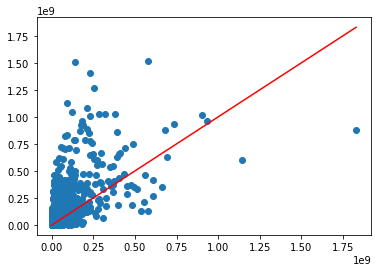

In [129]:
plt.plot(line, line, c='r')
plt.scatter(pred_train, y_train_c)

In [130]:
#ist(zip(pred_train, y_train, pred_train-y_train))

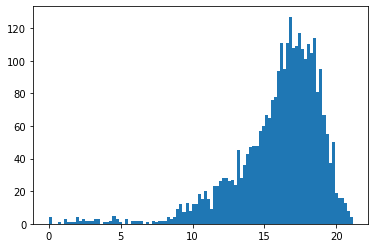

In [131]:
plt.hist(np.log(train_data['revenue']), bins=100)
plt.show()

In [132]:
pred_df = pd.DataFrame(data=zip(test_data.id, pred_test), columns=['id', 'revenue'])

In [133]:
pred_df['revenue'].mean(), pred_df['revenue'].max(), pred_df['revenue'].min()

(39844777.55566432, 3258471855.2876263, 17356.285437964383)

In [134]:
pred_df.loc[pred_df.revenue==pred_df['revenue'].max()].index

Int64Index([2155], dtype='int64')

In [135]:
#pred_df.to_csv('log_lasso.csv', index=False)

#### Forests

In [136]:
model = RandomForestRegressor(max_depth=12)

In [137]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12)

In [138]:
pred_test_raw = model.predict(X_test)
pred_train_raw = model.predict(X_train)

In [139]:
pred_train_rev_median = np.median(pred_train_raw[pred_train_raw>0])
pred_train_raw = np.where(pred_train_raw<0, pred_train_rev_median,  pred_train_raw)

pred_test_rev_median = np.median(pred_test_raw[pred_test_raw>0])
pred_test = np.where(pred_test_raw<0, pred_test_rev_median,  pred_test_raw)

In [140]:
pred_test = pd.Series(pred_test_raw).apply(lambda x: math.exp(x))
pred_train = pd.Series(pred_train_raw).apply(lambda x: math.exp(x))

y_train_c = pd.Series(y_train).apply(lambda x: math.exp(x)) 

In [141]:
r2_score(y_train_c, pred_train)\
, mean_squared_error(y_train_c, pred_train)\
, mean_absolute_error(y_train_c, pred_train)\
, mean_squared_log_error(y_train_c, pred_train)

(0.8728250420642212,
 2404730389908561.0,
 21670163.532600846,
 1.1194408864220784)

In [142]:
pred_df = pd.DataFrame(data=zip(test_data.id, pred_test), columns=['id', 'revenue'])

In [143]:
pred_df['revenue'].mean()

45727206.183442734

In [144]:
pred_df.to_csv('log_randomforest.csv', index=False)

In [145]:
#sorted(list(zip(model.feature_importances_, X_train.columns)), key=lambda x: abs(x[0]), reverse=True)

#### Catboost

In [616]:
X_train['belongs_to_collection'].fillna('No collection', inplace=True)
X_test['belongs_to_collection'].fillna('No collection', inplace=True)

In [617]:
model = CatBoostRegressor(random_state=42, max_depth=6, num_trees=1700, cat_features=['belongs_to_collection', 'original_language'])
model_1 = CatBoostRegressor(random_state=43, max_depth=6, num_trees=1700, cat_features=['belongs_to_collection', 'original_language'])
model_2 = CatBoostRegressor(random_state=44, max_depth=6, num_trees=1700, cat_features=['belongs_to_collection', 'original_language'])
#model_3 = CatBoostRegressor(random_state=45, max_depth=6, num_trees=1700, cat_features=['belongs_to_collection', 'original_language'])
#model_4 = CatBoostRegressor(random_state=46, max_depth=7, num_trees=1700, cat_features=['belongs_to_collection', 'original_language'])

In [618]:
#gs = GridSearchCV(model, param_grid={'num_trees':np.arange(1000, 2000, 100), 'max_depth':np.arange(2, 10, 1)}, cv=3, scoring='neg_mean_squared_log_error')

In [619]:
#gs.fit(X_train, y_train, silent=True)

In [620]:
#gs.best_params_

In [621]:
#sorted(sklearn.metrics.SCORERS.keys())

In [622]:
model.fit(X_train, y_train, silent=True)
model_1.fit(X_train, y_train, silent=True)
model_2.fit(X_train, y_train, silent=True)
#model_3.fit(X_train, y_train, silent=True)
#model_4.fit(X_train, y_train, silent=True)

In [623]:
model_pred_test = model.predict(X_test)
model_1_pred_test = model_1.predict(X_test)
model_2_pred_test = model_2.predict(X_test)
#model_3_pred_test = model_3.predict(X_test)
#model_4_pred_test = model_4.predict(X_test)

In [624]:
model_pred_train = model.predict(X_train)
model_1_pred_train = model_1.predict(X_train)
model_2_pred_train = model_2.predict(X_train)
#model_3_pred_train = model_3.predict(X_train)
#model_4_pred_train = model_4.predict(X_train)

In [625]:
pred_test_raw = pd.Series(zip(model_pred_test, model_1_pred_test, model_2_pred_test)).apply(lambda x: np.mean(x))

In [626]:
pred_train_raw = pd.Series(zip(model_pred_train, model_1_pred_train, model_2_pred_train)).apply(lambda x: np.mean(x))

In [627]:
#pred_test_raw = model.predict(X_test)
#pred_train_raw = model.predict(X_train)

In [628]:
#pred_train_rev_median = np.median(pred_train_raw[pred_train_raw>0])
#pred_train_raw = np.where(pred_train_raw<0, pred_train_rev_median,  pred_train_raw)

#pred_test_rev_median = np.median(pred_test_raw[pred_test_raw>0])
#pred_test = np.where(pred_test_raw<0, pred_test_rev_median,  pred_test_raw)

In [629]:
pred_test = pd.Series(pred_test_raw).apply(lambda x: math.exp(x))
pred_train = pd.Series(pred_train_raw).apply(lambda x: math.exp(x))

y_train_c = pd.Series(y_train).apply(lambda x: math.exp(x)) 

In [630]:
r2_score(y_train_c, pred_train)\
, mean_squared_error(y_train_c, pred_train)\
, mean_absolute_error(y_train_c, pred_train)\
, mean_squared_log_error(y_train_c, pred_train)

(0.8008375800046073, 3765929485366971.0, 27159138.24730188, 1.2170576253757042)

In [631]:
pred_df = pd.DataFrame(data=zip(test_data.id, pred_test), columns=['id', 'revenue'])

In [632]:
pred_df['revenue'].mean(), pred_df['revenue'].max(), pred_df['revenue'].min()

(52679051.767609105, 1414696817.9754632, 188.45237709892595)

In [634]:
line = np.arange(min(pred_train), max(pred_train), 1000)

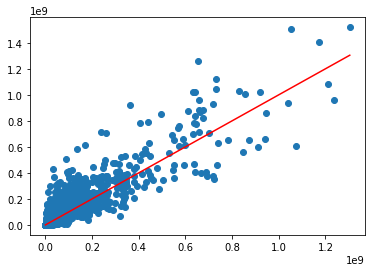

In [635]:
plt.plot(line, line, c='r')
plt.scatter(pred_train, y_train_c)

In [633]:
pred_df.to_csv('log_catboost.csv', index=False)

In [217]:
model.learning_rate_, model.random_seed_, model.tree_count_

(0.03704800084233284, 42, 1400)

In [218]:
sorted(list(zip(model.feature_importances_, X_train.columns)), key=lambda x: abs(x[0]), reverse=True)

[(23.24589668086836, 'budget'),
 (14.981179847066487, 'popularity'),
 (10.926181056636366, 'release_date_year'),
 (6.715031354680898, 'runtime'),
 (5.431383013284141, 'crew_cnt'),
 (4.703662037944945, 'cast_cnt'),
 (4.596265653186585, 'release_date_day'),
 (4.436794813886528, 'release_date_weekofyear'),
 (3.447024344165418, 'release_date_weekday'),
 (2.22141937836207, 'belongs_to_collection'),
 (1.9732380009643762, 'original_language'),
 (1.918999565689526, 'spoken_languages_en'),
 (1.7559095749588858, 'release_date_month'),
 (1.3961086204730337, 'Drama'),
 (1.2232723698574626, 'homepage'),
 (1.0759200605968728, 'Comedy'),
 (0.8708310265243397, 'spoken_languages_cnt'),
 (0.8300793153406163, 'Thriller'),
 (0.7510377557548917, 'spoken_languages_fr'),
 (0.6963924702948714, 'Romance'),
 (0.6523109375657902, 'Foreign'),
 (0.5949538950370079, 'Family'),
 (0.564662984256857, 'Crime'),
 (0.5246255846690682, 'Action'),
 (0.5035388427765657, 'has_collection'),
 (0.48036931749537903, 'Horror'),
 

In [167]:
ar = sorted(list(zip(pred_train, y_train_c, y_train_c - pred_train)), reverse=True)

In [168]:
ar[0][0] - ar[0][1]

197638098.22170353

In [169]:
ar[0][0], ar[0][1]

(1282577198.2217042, 1084939100.0000007)

In [170]:
#ar

In [171]:
#sorted(list(zip(pred_train, y_train_c, y_train_c - pred_train)), key=lambda x: abs(x[2]), reverse=True)

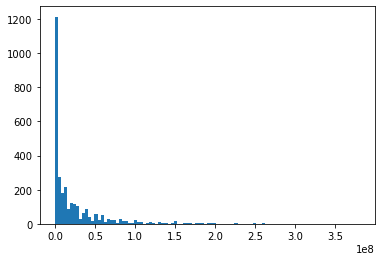

In [172]:
plt.hist(train_data['budget'], bins=100)
plt.show()

In [173]:
train_data['budget'].max()

380000000

In [174]:
train_data_c['original_language'].unique()

array([10, 16, 24, 34, 14, 20, 28, 43, 11,  6, 36,  5, 33, 39, 21, 12, 35,
        8, 37, 31, 26,  7, 13,  9, 40, 15, 29,  1, 27, 32, 41, 30, 17, 25,
        3, 18])

In [175]:
test_data_c['belongs_to_collection']

0       420
1         0
2         0
3         0
4         0
       ... 
4393      0
4394    731
4395      0
4396      0
4397      0
Name: belongs_to_collection, Length: 4398, dtype: int32

In [176]:
def my_func():
    my_var = 5
    return my_var + 10

In [177]:
my_func

<function __main__.my_func()>